In [ ]:
#IDEA: reduce I/O producing the whole batch with the Dataset.getitem() instead of the iterator
#means that we just shuffle the different batches instead of each batch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import librosa as lsa
ikala_path = ''
#%matplotlib inline
import matplotlib.pyplot as plt
import os
import h5py
import time

In [ ]:
def ikala_stfttodisk():
    #Firstly we open an HDF5 file for storing the dataset
    with h5py.File(ikala_path+'ikala_ch.hdf5', 'w') as hdf:
        #We list all the original audio files
        filenames=list(os.walk(ikala_path+'audio'))[0][2]
        #And initialize the dataset. We will store Vocals, Accom and their sum (mixture) in 32bit waveform
        hdf.create_dataset('audio_vocals', (len(filenames),1323008), np.float32) #track, time_samples
        hdf.create_dataset('audio_accom', (len(filenames),1323008), np.float32)
        hdf.create_dataset('audio_mixture', (len(filenames),1323008), np.float32)
        #We will also store mixture STFT magnitude (net input) and vocals & accompainment STFT magnitude (targets)
        hdf.create_dataset('vocals_mag', (len(filenames), 513, 5169), chunks=(1,513,30)) #track, freq_bin, t_frame
        hdf.create_dataset('accom_mag', (len(filenames), 513, 5169), chunks=(1,513,30))
        hdf.create_dataset('mixture_mag', (len(filenames), 513, 5169), chunks=(1,513,30))
        #Additionally, we will store mixture phases
        hdf.create_dataset('mixture_phase', (len(filenames), 513, 5169), chunks=(1,513,30))
        #And binwise statics for normalization if suitable. Computed with the online welford algorithm
        hdf.create_dataset('mean_vocal', (1,513), np.float32) #binwise statics
        hdf.create_dataset('mean_accom', (1,513), np.float32)
        hdf.create_dataset('mean_mixture', (1,513), np.float32)
        hdf.create_dataset('std_vocal', (1,513), np.float32)
        hdf.create_dataset('std_accom', (1,513), np.float32)
        hdf.create_dataset('std_mixture', (1,513), np.float32)
        #We start two counters: for each file and for each STFT frame
        file_ind=0
        n=0
        #We initialize mean and squared mean (Welford algorithm)
        mean_vocals=np.zeros(513)
        mean_accom=np.zeros(513)
        mean_mixture=np.zeros(513)
        M2_accom=np.zeros(513)
        M2_mixture=np.zeros(513)
        M2_vocals=np.zeros(513)
        for file in filenames:
            #Load vocals and accompainment from original ikala file
            aux=lsa.core.load(ikala_path+'audio/'+file, sr=None, mono=False)[0]
            accom=aux[0,:]
            vocals=aux[1,:]
            #Compute mixture
            mixture=accom+vocals
            #Normalize audio signals so mixture has maximum amplitude of 0.99
            norm=np.max((np.abs(np.min(mixture)), np.max(mixture)))
            accom=0.99*accom/norm
            vocals=0.99*vocals/norm
            mixture=0.99*mixture/norm
            #Store the audio waveforms in the HDF5
            hdf['audio_vocals'][file_ind, ...]=vocals
            hdf['audio_accom'][file_ind, ...]=accom
            hdf['audio_mixture'][file_ind, ...]=mixture
            #Compute STFTs with fft_size of 1024 and 75%overlap with hann window
            vocals_mag=np.abs(lsa.core.stft(vocals, n_fft=1024, hop_length=256, win_length=None, window='hann', center=True, dtype='complex64', pad_mode='reflect'))
            accom_mag=np.abs(lsa.core.stft(accom, n_fft=1024, hop_length=256, win_length=None, window='hann', center=True, dtype='complex64', pad_mode='reflect'))
            mixture_stft=lsa.core.stft(mixture, n_fft=1024, hop_length=256, win_length=None, window='hann', center=True, dtype='complex64', pad_mode='reflect')
            mixture_mag=np.abs(mixture_stft)
            mixture_phase=np.angle(mixture_stft)
            #Store them in HDF5
            hdf['vocals_mag'][file_ind, ...]=vocals_mag
            hdf['accom_mag'][file_ind, ...]=accom_mag
            hdf['mixture_mag'][file_ind, ...]=mixture_mag
            hdf['mixture_phase'][file_ind, ...]=mixture_phase
            print(str(len(filenames)-(file_ind+1))+' files remaining.')
            file_ind+=1
            for timeframe in range(vocals_mag.shape[1]):
                #Iterate over time STFT frames for Welford algorithm
                n+=1
                delta_vocals = vocals_mag[:,timeframe] - mean_vocals
                delta_accom = accom_mag[:,timeframe] - mean_accom
                delta_mixture = mixture_mag[:,timeframe] - mean_mixture
                mean_vocals = mean_vocals + delta_vocals/n
                mean_accom = mean_accom + delta_accom/n
                mean_mixture = mean_mixture + delta_mixture/n
                M2_vocals = M2_vocals + delta_vocals *(vocals_mag[:,timeframe] - mean_vocals)
                M2_accom = M2_accom + delta_accom *(accom_mag[:,timeframe] - mean_accom)
                M2_mixture = M2_mixture + delta_mixture *(mixture_mag[:,timeframe] - mean_mixture)
        #Store statics        
        hdf['mean_vocal'][0,...]=mean_vocals
        hdf['mean_accom'][0,...]=mean_accom
        hdf['mean_mixture'][0,...]=mean_mixture
        hdf['std_vocal'][0,...]=np.sqrt(M2_vocals/(n-1))
        hdf['std_accom'][0,...]=np.sqrt(M2_accom/(n-1))
        hdf['std_mixture'][0,...]=np.sqrt(M2_mixture/(n-1))
        #Close the HDF5 file
        hdf.close()

ikala_stfttodisk()


In [1]:
#IDEA: reduce I/O producing the whole batch with the Dataset.getitem() instead of the iterator
#means that we just shuffle the different batches instead of each batch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import librosa as lsa
ikala_path = ''
#%matplotlib inline
import matplotlib.pyplot as plt
import os
import h5py
import time

batch_size=30
split=0.9
tcontext=30
normalize='std'

class IkalaDataset(Dataset):
    """Ikala voice-accompainment dataset."""

    def __init__(self, root_dir, tcontext, normalize, split, mode):
        """
        Args:
            root_dir (string): Directory with the hdf5 file.
            tcontext: temporal context window size
            transform: logarithmic compression of the STFTs (str)
        """
        #self.dataset=h5py.File(root_dir, 'r')
        self.root_dir=root_dir
        self.tcontext=tcontext
        self.normalize=normalize
        self.split=split
        self.mode=mode
        with h5py.File(self.root_dir, 'r') as db:
            self.train_utterances=int(np.ceil(len(db['vocals_mag'])*self.split))
            self.val_utterances=int(len(db['vocals_mag'])*(1-self.split))
            self.utterance_chunks=int(db['vocals_mag'].shape[2]/self.tcontext)
    def __len__(self):
        #Returns the length of the dataset
        if self.mode=='train':
            lens=self.train_utterances*self.utterance_chunks
        else:
            lens=self.val_utterances*self.utterance_chunks
        return lens

    def __getitem__(self, idx):
        #get the slice using the index idx
        with h5py.File(self.root_dir, 'r') as db:
            if self.mode=='train':
                reader_head=idx
            else:
                reader_head=idx+self.train_utterances*self.utterance_chunks
                
            vocal_mag=db['vocals_mag'][int(reader_head/self.utterance_chunks),:,reader_head%self.utterance_chunks:self.tcontext+reader_head%self.utterance_chunks]
            accom_mag=db['accom_mag'][int(reader_head/self.utterance_chunks),:,reader_head%self.utterance_chunks:self.tcontext+reader_head%self.utterance_chunks]
            mixture_mag=db['mixture_mag'][int(reader_head/self.utterance_chunks),:,reader_head%self.utterance_chunks:self.tcontext+reader_head%self.utterance_chunks]

            if self.normalize=='std':
                vocal_mag=vocal_mag/np.swapaxes(np.tile(db['std_vocal'][0],(self.tcontext,1)), 0,1)
                accom_mag=accom_mag/np.swapaxes(np.tile(db['std_accom'][0],(self.tcontext,1)), 0,1)
                mixture_mag=mixture_mag/np.swapaxes(np.tile(db['std_mixture'][0],(self.tcontext,1)), 0,1)

            #pass them to torch tensors
            vocal_mag=torch.from_numpy(vocal_mag)
            vocal_mag=vocal_mag.unsqueeze(0) #Add singleton dimension for (1ch CNN)
            accom_mag=torch.from_numpy(accom_mag)
            accom_mag=accom_mag.unsqueeze(0)
            mixture_mag=torch.from_numpy(mixture_mag)
            mixture_mag=mixture_mag.unsqueeze(0)
            sample = {'vocal_mag': vocal_mag, 'accom_mag': accom_mag, 'mixture_mag':mixture_mag}

        return sample
    def get_target_statics(self):
        with h5py.File(self.root_dir, 'r') as db:
            mix_std=np.swapaxes(np.tile(db['std_mixture'][0],(self.tcontext,1)), 0,1)
            mix_mean=np.swapaxes(np.tile(db['mean_mixture'][0],(self.tcontext,1)), 0,1)
        return mix_std, mix_mean
        

train_dataset=IkalaDataset(ikala_path+'ikala_ch.hdf5', tcontext, normalize, split, mode='train')
val_dataset=IkalaDataset(ikala_path+'ikala_ch.hdf5', tcontext, normalize, split, mode='val')

In [12]:
train_dataset[3]
train_loader=DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, drop_last=True)
val_loader=DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

torch.Size([30, 1, 513, 30])

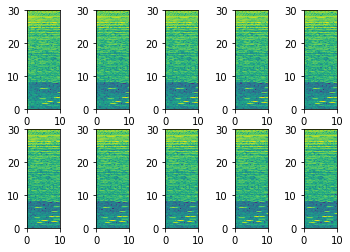

In [13]:
#Visualize a batch
for x in val_loader:
    break
plt.subplot(2,5,1)
plt.imshow(np.log10(x['accom_mag'][0, :,:].squeeze().numpy()), extent=[0,10,0,30])
plt.subplot(2,5,2)
plt.imshow(np.log10(x['accom_mag'][1, :,:].squeeze().numpy()), extent=[0,10,0,30])
plt.subplot(2,5,3)
plt.imshow(np.log10(x['accom_mag'][2, :,:].squeeze().numpy()), extent=[0,10,0,30])
plt.subplot(2,5,4)
plt.imshow(np.log10(x['accom_mag'][3, :,:].squeeze().numpy()), extent=[0,10,0,30])
plt.subplot(2,5,5)
plt.imshow(np.log10(x['accom_mag'][4, :,:].squeeze().numpy()), extent=[0,10,0,30])
plt.subplot(2,5,6)
plt.imshow(np.log10(x['accom_mag'][5, :,:].squeeze().numpy()), extent=[0,10,0,30])
plt.subplot(2,5,7)
plt.imshow(np.log10(x['accom_mag'][6, :,:].squeeze().numpy()), extent=[0,10,0,30])
plt.subplot(2,5,8)
plt.imshow(np.log10(x['accom_mag'][7, :,:].squeeze().numpy()), extent=[0,10,0,30])
plt.subplot(2,5,9)
plt.imshow(np.log10(x['accom_mag'][8, :,:].squeeze().numpy()), extent=[0,10,0,30])
plt.subplot(2,5,10)
plt.imshow(np.log10(x['accom_mag'][9, :,:].squeeze().numpy()), extent=[0,10,0,30])
x['vocal_mag'].shape

In [4]:
#Now we will define our model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 50, (513,1)) #outputs batch_size x 50 x 1 x 30
        self.conv2 = nn.Conv2d(50, 50, (1, 12)) #outputs batch_size x 50 x 1 x 19
        self.fc1 = nn.Linear(50*19, 128) #outputs batch_size x 128
        self.fc2 = nn.Linear(128, 50*19)
        self.fc3 = nn.Linear(128, 50*19)
        self.deconv1=nn.ConvTranspose2d(50, 50, (1,12))
        self.deconv2=nn.ConvTranspose2d(50, 1, (513,1))
        self.deconv3=nn.ConvTranspose2d(50, 50, (1,12))
        self.deconv4=nn.ConvTranspose2d(50, 1, (513,1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(-1, 50*19)
        x = self.fc1(x)
        x_vocal = self.fc2(x)
        x_accom = self.fc3(x)
        x_vocal = x_vocal.view(-1, 50, 1, 19)
        x_accom = x_accom.view(-1, 50, 1, 19)
        x_vocal = self.deconv1(x_vocal)
        x_vocal = self.deconv2(x_vocal)
        x_accom = self.deconv3(x_accom)
        x_accom = self.deconv4(x_accom)
        
        #We apply Relu
        ####################### TO DO: compare applying relu to x_accom and x_vocal separatedly ###########
        x_vocal = nn.functional.relu(torch.cat((x_vocal, x_accom)))[0:30]
        x_accom = nn.functional.relu(torch.cat((x_vocal, x_accom)))[30:]
        return {'vocal_out': x_vocal, 'accom_out': x_accom}
    
net = Net()

#If you wabnt to work with iterators instead of generators:
#dataloader=iter(dataloader)
if torch.cuda.is_available():
    net.cuda()

criterion=nn.MSELoss()
lr=0.001
optimizer=torch.optim.Adadelta(net.parameters(), lr)

In [8]:
num_epochs=50
training_epoch_loss=torch.zeros(num_epochs)
val_epoch_loss=torch.zeros(num_epochs)
#Training loop
i=0
for epoch in range(num_epochs):
    start = time.time()
    
    #training:
    running_loss=0.0
    for x in train_loader:
        if torch.cuda.is_available():
            vocal=torch.autograd.Variable(x['vocal_mag'].cuda())
            accom=torch.autograd.Variable(x['accom_mag'].cuda())
            mixture=torch.autograd.Variable(x['mixture_mag'].cuda())
        else:
            vocal=torch.autograd.Variable(x['vocal_mag'])
            accom=torch.autograd.Variable(x['accom_mag'])
            mixture=torch.autograd.Variable(x['mixture_mag'])
        
        optimizer.zero_grad()
        outputs=net(mixture)
        loss=criterion(outputs['vocal_out'], vocal)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #i=i+1
    running_loss=running_loss/int(len(train_loader.dataset)/train_loader.batch_size)
    training_epoch_loss[epoch]=running_loss
    
    #validation
    running_loss=0.0
    for x in val_loader:
        if torch.cuda.is_available():
            vocal=torch.autograd.Variable(x['vocal_mag'].cuda())
            accom=torch.autograd.Variable(x['accom_mag'].cuda())
            mixture=torch.autograd.Variable(x['mixture_mag'].cuda())
        else:
            vocal=torch.autograd.Variable(x['vocal_mag'])
            accom=torch.autograd.Variable(x['accom_mag'])
            mixture=torch.autograd.Variable(x['mixture_mag'])
        
        #optimizer.zero_grad()
        outputs=net(mixture)
        loss=criterion(outputs['vocal_out'], vocal)
        #loss.backward()
        #optimizer.step()
        running_loss += loss.item()
        #i=i+1
    running_loss=running_loss/int(len(val_loader.dataset)/val_loader.batch_size)
    val_epoch_loss[epoch]=running_loss
    
    print('Epoch '+str(epoch)+' took '+str(time.time()-start)+'. Losses = '+str(training_epoch_loss[epoch])+' '+str(val_epoch_loss[epoch]))

Epoch 0 took 189.22895526885986. Losses = tensor(0.4628) tensor(0.1530)
Epoch 1 took 354.51145911216736. Losses = tensor(0.3518) tensor(0.1888)
Epoch 2 took 178.027761220932. Losses = tensor(0.3245) tensor(0.1568)
Epoch 3 took 178.19244003295898. Losses = tensor(0.3078) tensor(0.1727)
Epoch 4 took 178.05168199539185. Losses = tensor(0.2944) tensor(0.1589)
Epoch 5 took 178.6451358795166. Losses = tensor(0.2865) tensor(0.1491)
Epoch 6 took 178.80415797233582. Losses = tensor(0.2817) tensor(0.1759)
Epoch 7 took 178.2890419960022. Losses = tensor(0.2779) tensor(0.1461)
Epoch 8 took 178.2794258594513. Losses = tensor(0.2752) tensor(0.1816)
Epoch 9 took 181.4266538619995. Losses = tensor(0.2719) tensor(0.1608)
Epoch 10 took 178.00647902488708. Losses = tensor(0.2680) tensor(0.1988)
Epoch 11 took 178.18819308280945. Losses = tensor(0.2636) tensor(0.1923)
Epoch 12 took 180.00721406936646. Losses = tensor(0.2596) tensor(0.1622)
Epoch 13 took 178.58290886878967. Losses = tensor(0.2558) tensor(0.

Traceback (most recent call last):
  File "/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Traceback (most recent call last):
  File "/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/envs/pytorch/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaco

KeyboardInterrupt: 

In [ ]:
#tips:        
    #lsa.output.write_wav('./mixture', mixture, 44100, norm=False)
        #lsa.output.write_wav('./accom', accom, 44100, norm=False)
        #lsa.output.write_wav('./vocals', vocals, 44100, norm=False)
        #plt.imshow(np.log10(np.abs(librosa_stft)), extent=[0, 1, 0, 1])  
#We get a sample and do STFT on GPU with pytorch. We get back to CPU
#sample=inputs[0,:]
#print(sample.shape)
#Compute STFT in pytorch GPU
#samp_GPU_audio=torch.autograd.Variable(torch.FloatTensor(sample), requires_grad=False).unsqueeze(0).cuda()
#samp_GPU_audio.device
#samp_GPU_audio.shape
#samp_GPU_stft=torch.stft(samp_GPU_audio, 1024, hop_length=None, win_length=None, window=torch.hann_window(1024).cuda(), center=True, pad_mode='reflect', normalized=False, onesided=True)
#samp_GPU_stft.device
#samp_GPU_stft=samp_GPU_stft.squeeze()
#print(samp_GPU_stft.shape)